## Temperature by element

The main objective of this script is to estimate the average Temperature for each element of the PV field (panels, soil and shade) for the mid-day period (10:00 - 15:00), in order to compare it with the thermocouples analysis and sumarize it in a table.

In [19]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from scipy import stats
import os
from plotnine.data import mtcars
from itertools import product

## Functions

In [20]:
def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

In [21]:
# This file is created in sup_met_S4_uav_mobile_lout
pv_df = pd.read_csv("temperature_by_element.csv")

# convertiog date_time to proper format
pv_df['date_time'] = pd.to_datetime(pv_df['date_time'], format='%Y-%m-%d %H:%M:%S', utc=True)

# rename columns
pv_df.rename(columns={'T_object': 'Ts'}, inplace=True)

# Remove unrealistic values
pv_df.loc[pv_df['Ts'] < 20, 'Ts'] = np.nan
pv_df.loc[pv_df['coverage_percent'] < 1, 'Ts'] = np.nan

# Keep only relevant columns
pv_df = pv_df[['flight','label','date_time','Ts']]

display(pv_df)

,flight,label,date_time,Ts
0,20181024_1200,panel,2018-10-24 12:00:00+00:00,42.521814
1,20181024_1200,shadow,2018-10-24 12:00:00+00:00,32.664162
2,20181024_1200,soil,2018-10-24 12:00:00+00:00,39.982280
3,20181024_1200,sun,2018-10-24 12:00:00+00:00,NaN
4,20181024_1430,panel,2018-10-24 14:30:00+00:00,34.711900
...,...,...,...,...
219,20190723_1430,shadow,2019-07-23 14:30:00+00:00,43.363623
220,20190723_1430,soil,2019-07-23 14:30:00+00:00,51.131766
221,20190723_1715,panel,2019-07-23 17:15:00+00:00,43.035199
222,20190723_1715,shadow,2019-07-23 17:15:00+00:00,NaN


In [22]:
# t-test

a = pv_df.loc[(pv_df['label'] == 'shadow') & (pv_df['date_time'].dt.year == 2018),'Ts']
b = pv_df.loc[(pv_df['label'] == 'soil') & (pv_df['date_time'].dt.year == 2018),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Shadow vs. soil 2018: P =', pvalue_text(t[1]))

a = pv_df.loc[(pv_df['label'] == 'shadow') & (pv_df['date_time'].dt.year == 2019),'Ts']
b = pv_df.loc[(pv_df['label'] == 'soil') & (pv_df['date_time'].dt.year == 2019),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Shadow vs. soil 2019: P =', pvalue_text(t[1]))

a = pv_df.loc[(pv_df['label'] == 'shadow') & (pv_df['date_time'].dt.year == 2018),'Ts']
b = pv_df.loc[(pv_df['label'] == 'panel') & (pv_df['date_time'].dt.year == 2018),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Shadow vs. panel 2018: P =', pvalue_text(t[1]))

a = pv_df.loc[(pv_df['label'] == 'shadow') & (pv_df['date_time'].dt.year == 2019),'Ts']
b = pv_df.loc[(pv_df['label'] == 'panel') & (pv_df['date_time'].dt.year == 2019),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Shadow vs. panel 2019: P =', pvalue_text(t[1]))

a = pv_df.loc[(pv_df['label'] == 'panel') & (pv_df['date_time'].dt.year == 2018),'Ts']
b = pv_df.loc[(pv_df['label'] == 'soil') & (pv_df['date_time'].dt.year == 2018),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Panel vs. soil 2018: P =', pvalue_text(t[1]))

a = pv_df.loc[(pv_df['label'] == 'panel') & (pv_df['date_time'].dt.year == 2019),'Ts']
b = pv_df.loc[(pv_df['label'] == 'soil') & (pv_df['date_time'].dt.year == 2019),'Ts']
t = stats.ttest_rel(a, b, nan_policy='omit') # Welch t-test for inequal variances
print('Panel vs. soil 2019: P =', pvalue_text(t[1]))

Shadow vs. soil 2018: P = <.001
Shadow vs. soil 2019: P = <.001
Shadow vs. panel 2018: P = <.001
Shadow vs. panel 2019: P = <.001
Panel vs. soil 2018: P = <.001
Panel vs. soil 2019: P = <.001


In [23]:
out_df = pv_df.pivot(index='date_time', columns='label', values=['Ts'])
out_df.columns = list(map('_'.join, out_df.columns.values))
out_df = out_df.reset_index()

display(out_df)

,date_time,Ts_panel,Ts_shadow,Ts_soil,Ts_sun
0,2018-10-24 12:00:00+00:00,42.521814,32.664162,39.982280,NaN
1,2018-10-24 14:30:00+00:00,34.711900,30.321746,34.315464,NaN
2,2018-10-24 15:00:00+00:00,34.200336,33.672135,35.754370,NaN
3,2018-10-24 18:00:00+00:00,31.007627,31.334820,32.259542,NaN
4,2018-10-25 06:30:00+00:00,29.459496,NaN,29.638469,NaN
...,...,...,...,...,...
57,2019-07-22 15:00:00+00:00,49.182552,41.819334,48.895763,NaN
58,2019-07-23 10:45:00+00:00,53.886471,42.934076,48.574916,NaN
59,2019-07-23 12:45:00+00:00,53.268228,43.238313,51.041797,NaN
60,2019-07-23 14:30:00+00:00,52.186156,43.363623,51.131766,NaN


In [25]:
# Preparing for graph
out_df['Time'] = out_df['date_time'].dt.strftime('%H:%M')
out_df['Month'] = out_df['date_time'].dt.strftime('%m')

out_df.loc[out_df['Month'] == '07', 'Season'] = 'Summer'
out_df.loc[out_df['Month'] == '10', 'Season'] = 'Autumn'

out_df.rename(columns={'Ts_panel': 'Panel'}, inplace=True)
out_df.rename(columns={'Ts_shadow': 'Shade'}, inplace=True)
out_df.rename(columns={'Ts_soil': 'Soil'}, inplace=True)

display(out_df)

out_df.to_csv('temperature_elements_drone.csv', index=False)

,date_time,Panel,Shade,Soil,Ts_sun,Time,Month,Season
0,2018-10-24 12:00:00+00:00,42.521814,32.664162,39.982280,NaN,12:00,10,Autumn
1,2018-10-24 14:30:00+00:00,34.711900,30.321746,34.315464,NaN,14:30,10,Autumn
2,2018-10-24 15:00:00+00:00,34.200336,33.672135,35.754370,NaN,15:00,10,Autumn
3,2018-10-24 18:00:00+00:00,31.007627,31.334820,32.259542,NaN,18:00,10,Autumn
4,2018-10-25 06:30:00+00:00,29.459496,NaN,29.638469,NaN,06:30,10,Autumn
...,...,...,...,...,...,...,...,...
57,2019-07-22 15:00:00+00:00,49.182552,41.819334,48.895763,NaN,15:00,07,Summer
58,2019-07-23 10:45:00+00:00,53.886471,42.934076,48.574916,NaN,10:45,07,Summer
59,2019-07-23 12:45:00+00:00,53.268228,43.238313,51.041797,NaN,12:45,07,Summer
60,2019-07-23 14:30:00+00:00,52.186156,43.363623,51.131766,NaN,14:30,07,Summer


# Include air temperature in the graph

In [26]:
temp_df = pd.read_csv("diurnal_temp.csv")

#temp_df['Ta_autumn'] = 'na'
#temp_df['Ta_autumn_sd'] = 'na'
#temp_df['Ta_summer'] = 'na'
#temp_df['Ta_summer_sd'] = 'na'
#temp_df.loc[((temp_df['Season'].isin(['Autumn'])) & (temp_df['Ecosystem'] == 'PV field')), 'Ta_autumn'] = \
#temp_df.loc[((temp_df['Season'].isin(['Autumn'])) & (temp_df['Ecosystem'] == 'PV field')), 'Temperature_mean']
#temp_df.loc[((temp_df['Season'].isin(['Autumn'])) & (temp_df['Ecosystem'] == 'PV field')), 'Ta_autumn_sd'] = \
#temp_df.loc[((temp_df['Season'].isin(['Autumn'])) & (temp_df['Ecosystem'] == 'PV field')), 'Temperature_sd']

#temp_df.loc[((temp_df['Season'].isin(['Summer'])) & (temp_df['Ecosystem'] == 'PV field')), 'Ta_summer'] = \
#temp_df.loc[((temp_df['Season'].isin(['Summer'])) & (temp_df['Ecosystem'] == 'PV field')), 'Temperature_mean']
#temp_df.loc[((temp_df['Season'].isin(['Summer'])) & (temp_df['Ecosystem'] == 'PV field')), 'Ta_summer_sd'] = \
#temp_df.loc[((temp_df['Season'].isin(['Summer'])) & (temp_df['Ecosystem'] == 'PV field')), 'Temperature_sd']

temp_df['timestamp2'] = pd.to_datetime(temp_df['Time'], utc=True)
temp_df = temp_df.loc[(temp_df['Ecosystem'] == 'PV field') & (temp_df['Season'].isin(['Autumn','Summer']))].copy()

temp_df.rename(columns={'Temperature_mean': 'Ta'}, inplace=True)
temp_df.rename(columns={'Temperature_sd': 'Ta_sd'}, inplace=True)

temp_df.drop(['Ecosystem','Time'], axis=1, inplace=True)

temp_df = temp_df.loc[(temp_df['timestamp2'].dt.hour >= 6) & (temp_df['timestamp2'].dt.hour <= 21)]

display(temp_df)

,Season,Ta,Ta_sd,timestamp2
156,Autumn,21.793434,3.649349,2022-08-24 06:00:00+00:00
157,Autumn,22.805378,2.967234,2022-08-24 06:30:00+00:00
158,Autumn,22.956238,2.617482,2022-08-24 07:00:00+00:00
159,Autumn,23.924007,2.264853,2022-08-24 07:30:00+00:00
160,Autumn,24.848284,2.186221,2022-08-24 08:00:00+00:00
...,...,...,...,...
279,Summer,37.525005,1.778946,2022-08-24 19:30:00+00:00
280,Summer,36.527504,1.797002,2022-08-24 20:00:00+00:00
281,Summer,35.636257,1.690557,2022-08-24 20:30:00+00:00
282,Summer,34.978752,1.810315,2022-08-24 21:00:00+00:00


In [27]:
# Convert the times back to a “fake” timestamp:
out_df['timestamp2'] = pd.to_datetime(out_df['Time'], utc=True)

out_df2 = out_df.merge(temp_df, how='outer', on=['Season','timestamp2'])

display(out_df2)

,date_time,Panel,Shade,Soil,Ts_sun,Time,Month,Season,timestamp2,Ta,Ta_sd
0,2018-10-24 12:00:00+00:00,42.521814,32.664162,39.982280,NaN,12:00,10,Autumn,2022-08-24 12:00:00+00:00,29.247145,1.884510
1,2018-10-25 12:00:00+00:00,32.916926,NaN,31.994649,NaN,12:00,10,Autumn,2022-08-24 12:00:00+00:00,29.247145,1.884510
2,2018-10-27 12:00:00+00:00,47.588487,31.456158,40.329616,NaN,12:00,10,Autumn,2022-08-24 12:00:00+00:00,29.247145,1.884510
3,2018-10-29 12:00:00+00:00,44.261877,32.797424,38.104094,NaN,12:00,10,Autumn,2022-08-24 12:00:00+00:00,29.247145,1.884510
4,2018-10-31 12:00:00+00:00,49.466619,34.469269,42.224288,NaN,12:00,10,Autumn,2022-08-24 12:00:00+00:00,29.247145,1.884510
...,...,...,...,...,...,...,...,...,...,...,...
94,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2022-08-24 19:00:00+00:00,38.136257,1.792302
95,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2022-08-24 19:30:00+00:00,37.525005,1.778946
96,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2022-08-24 20:00:00+00:00,36.527504,1.797002
97,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2022-08-24 20:30:00+00:00,35.636257,1.690557


In [28]:
a = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Panel']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. panel 2018 (Autumn): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Summer'),'Panel']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. panel 2019 (Summer): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Soil']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. soil 2018 (Autumn): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Summer'),'Soil']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. soil 2019 (Summer): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Shade']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. shade 2018 (Autumn): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Summer'),'Shade']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Ta vs. shade 2019 (Summer): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Ta']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Ta']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
print('Summer vs. Autumn (Ta): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Shade']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Shade']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
print('Summer vs. Autumn (Shade): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Soil']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Soil']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
print('Summer vs. Autumn (Soil): P =', pvalue_text(t[1]))

a = out_df2.loc[(out_df2['Season'] == 'Summer'),'Panel']
b = out_df2.loc[(out_df2['Season'] == 'Autumn'),'Panel']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
print('Summer vs. Autumn (Panel): P =', pvalue_text(t[1]))

Ta vs. panel 2018 (Autumn): P = <.001
Ta vs. panel 2019 (Summer): P = <.001
Ta vs. soil 2018 (Autumn): P = <.001
Ta vs. soil 2019 (Summer): P = <.001
Ta vs. shade 2018 (Autumn): P = <.001
Ta vs. shade 2019 (Summer): P = <.001
Summer vs. Autumn (Ta): P = <.001
Summer vs. Autumn (Shade): P = <.001
Summer vs. Autumn (Soil): P = <.001
Summer vs. Autumn (Panel): P = <.001


C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 7.0 cm image.
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: temperature_elements.pdf
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 142 rows containing missing values.
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 7.0 cm image.
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: temperature_elements.png
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 142 rows containing missing values.
C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 142 rows containing missing values.


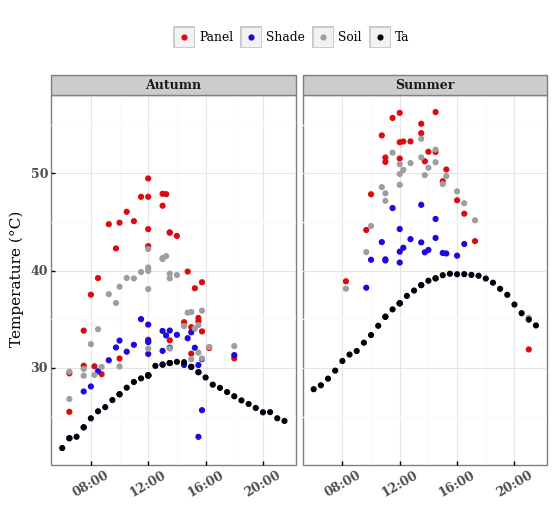

<ggplot: (-9223371896533412720)>

In [33]:
cbPalette = ["#DE090F","#1B07E1","#9e9e9e","#02000B"]

# Makes long format
temp = pd.melt(out_df2, id_vars=['Season','Time','timestamp2'], value_vars=['Panel','Shade','Soil','Ta'])

plt = ggplot(temp)
#plt = plt + geom_line(aes(x='timestamp2', y='value'))
plt = plt + geom_point(aes(x='timestamp2', y='value',color='variable'))
#plt = plt + geom_ribbon(aes(x='date_time', ymin='LWout_mean - LWout_sd', ymax='LWout_mean + LWout_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='Temperature (°C)', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + scale_colour_manual(values=cbPalette) #+ scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  #axis_title_x=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '4 hours', date_labels = '%H:%M')

plt.save('temperature_elements.pdf', width=19, height=7, units='cm', dpi=600)
plt.save('temperature_elements.png', width=19, height=7, units='cm', dpi=600)


plt

In [8]:
ts_df = pd.read_csv("Thermocouples data for graph.csv")

# rename columns
ts_df.rename(columns={'temp2': 'Shade'}, inplace=True)
ts_df.rename(columns={'temp4': 'Air under panels'}, inplace=True)
ts_df.rename(columns={'temp6': 'half sun'}, inplace=True)
ts_df.rename(columns={'temp8': 'Soil'}, inplace=True)
ts_df.rename(columns={'temp9': 'Panel'}, inplace=True)

ts_df['date_mid_hour'] = pd.to_datetime(ts_df['date_mid_hour'], format='%Y-%m-%d %H:%M:%S', utc=True)
ts_df['Period'] = 'Night'
ts_df.loc[(ts_df['date_mid_hour'].dt.hour >= 6) & (ts_df['date_mid_hour'].dt.hour < 19), 'Period'] = 'Day'

# Keep only relevant columns
ts_df = ts_df[['date_mid_hour','Period','Shade','Soil','Panel']]

display(ts_df)

,date_mid_hour,Period,Shade,Soil,Panel
0,2019-07-17 00:00:00+00:00,Night,33.95,34.16,24.09
1,2019-07-17 00:00:00+00:00,Night,NaN,NaN,NaN
2,2019-07-17 00:01:00+00:00,Night,33.20,35.06,24.07
3,2019-07-17 00:02:00+00:00,Night,34.21,35.94,24.05
4,2019-07-17 00:03:00+00:00,Night,34.22,34.09,24.03
...,...,...,...,...,...
10082,2019-07-23 23:57:00+00:00,Night,34.35,34.59,27.00
10083,2019-07-23 23:58:00+00:00,Night,34.27,36.23,26.96
10084,2019-07-23 23:59:00+00:00,Night,33.82,37.08,26.88
10085,2019-07-24 00:00:00+00:00,Night,34.35,35.39,26.94


In [9]:
# define mid-day and year
out19_df = out_df.loc[(out_df['date_time'].dt.hour >= 10) & (out_df['date_time'].dt.hour < 15) & (out_df['date_time'].dt.year == 2019)].copy() 

display(out19_df)

,date_time,Panel,Shade,Soil,T_sun,Time,Month,Season,timestamp2
38,2019-07-17 11:30:00+00:00,66.387634,52.619361,57.795921,NaN,11:30,07,Summer,2021-09-27 11:30:00+00:00
39,2019-07-17 13:30:00+00:00,65.904270,52.998788,59.171726,NaN,13:30,07,Summer,2021-09-27 13:30:00+00:00
41,2019-07-18 10:00:00+00:00,58.731122,47.561654,50.703872,NaN,10:00,07,Summer,2021-09-27 10:00:00+00:00
42,2019-07-18 12:00:00+00:00,66.746913,50.532680,56.583271,NaN,12:00,07,Summer,2021-09-27 12:00:00+00:00
43,2019-07-18 14:30:00+00:00,66.983974,51.630143,58.102261,NaN,14:30,07,Summer,2021-09-27 14:30:00+00:00
45,2019-07-19 12:15:00+00:00,63.649965,48.476380,55.757880,NaN,12:15,07,Summer,2021-09-27 12:15:00+00:00
46,2019-07-19 14:00:00+00:00,62.723585,48.342551,56.030481,NaN,14:00,07,Summer,2021-09-27 14:00:00+00:00
48,2019-07-20 11:00:00+00:00,61.952371,47.155173,52.728213,NaN,11:00,07,Summer,2021-09-27 11:00:00+00:00
49,2019-07-20 12:00:00+00:00,63.507254,48.043011,55.308871,NaN,12:00,07,Summer,2021-09-27 12:00:00+00:00
50,2019-07-20 13:30:00+00:00,64.435526,48.950037,56.908979,NaN,13:30,07,Summer,2021-09-27 13:30:00+00:00


In [10]:
out19_df.describe()

,Panel,Shade,Soil,T_sun
count,16.000000,16.000000,16.000000,0.0
mean,63.575113,49.175429,55.597055,NaN
std,2.208973,1.871551,2.141209,NaN
min,58.731122,47.013711,50.703872,NaN
25%,61.940097,47.922672,54.251185,NaN
50%,63.578610,48.713208,55.894181,NaN
75%,64.802712,49.767356,56.669714,NaN
max,66.983974,52.998788,59.171726,NaN


In [11]:
os.chdir('D:/Group members Rafael/Analyses/Ketura Solar/Lior segmentation analysis')

ts_df = pd.read_csv("Thermocouples data for graph.csv")

# rename columns
ts_df.rename(columns={'temp2': 'Shade'}, inplace=True)
ts_df.rename(columns={'temp4': 'Air under panels'}, inplace=True)
ts_df.rename(columns={'temp6': 'half sun'}, inplace=True)
ts_df.rename(columns={'temp8': 'Soil'}, inplace=True)
ts_df.rename(columns={'temp9': 'Panel'}, inplace=True)

ts_df['date_mid_hour'] = pd.to_datetime(ts_df['date_mid_hour'], format='%Y-%m-%d %H:%M:%S', utc=True)

# Keep only relevant columns
ts_df = ts_df[['date_mid_hour','Shade','Soil','Panel']]

display(ts_df)

,date_mid_hour,Shade,Soil,Panel
0,2019-07-17 00:00:00+00:00,33.95,34.16,24.09
1,2019-07-17 00:00:00+00:00,NaN,NaN,NaN
2,2019-07-17 00:01:00+00:00,33.20,35.06,24.07
3,2019-07-17 00:02:00+00:00,34.21,35.94,24.05
4,2019-07-17 00:03:00+00:00,34.22,34.09,24.03
...,...,...,...,...
10082,2019-07-23 23:57:00+00:00,34.35,34.59,27.00
10083,2019-07-23 23:58:00+00:00,34.27,36.23,26.96
10084,2019-07-23 23:59:00+00:00,33.82,37.08,26.88
10085,2019-07-24 00:00:00+00:00,34.35,35.39,26.94


In [12]:
# define mid-day
ts_df = ts_df.loc[(ts_df['date_mid_hour'].dt.hour >= 10) & (ts_df['date_mid_hour'].dt.hour < 15)].copy() 

display (ts_df)

,date_mid_hour,Shade,Soil,Panel
601,2019-07-17 10:00:00+00:00,32.60,37.50,65.27
602,2019-07-17 10:01:00+00:00,32.95,38.00,65.45
603,2019-07-17 10:02:00+00:00,33.32,36.76,65.65
604,2019-07-17 10:03:00+00:00,33.41,35.39,65.70
605,2019-07-17 10:04:00+00:00,33.05,38.45,65.93
...,...,...,...,...
9542,2019-07-23 14:55:00+00:00,36.29,45.28,69.15
9543,2019-07-23 14:56:00+00:00,36.66,48.95,69.24
9544,2019-07-23 14:57:00+00:00,36.49,48.57,69.13
9545,2019-07-23 14:58:00+00:00,36.16,45.95,68.94


In [13]:
ts_df.describe()

,Shade,Soil,Panel
count,2100.000000,2100.000000,2100.000000
mean,35.217071,43.492429,71.209638
std,1.719197,3.401729,4.040511
min,31.580000,34.880000,56.960000
25%,33.940000,40.897500,69.147500
50%,35.120000,44.040000,71.950000
75%,36.292500,46.100000,73.600000
max,39.940000,52.040000,79.500000
